# Выпускной проект: телекоммуникации

Описание проекта: 

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

Описание услуг

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Файл contract_new.csv:

- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Файл personal_new.csv:

- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Файл internet_new.csv

- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Файл phone_new.csv

- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

# План работы
- Шаг 1. Загрузка данных
- Шаг 2. Исследовательский анализ и предобработка данных
- Шаг 3. Объединение данных
- Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма
- Шаг 5. Подготовка данных
- Шаг 6. Обучение моделей машинного обучения
- Шаг 7. Выбор лучшей модели
- Шаг 8. Общий вывод и рекомендации заказчику

## Загрузка данных 

In [1]:
!pip install -U pyodbc -q

!pip install -U numpy -q
!pip install -U pandas -q 
!pip install -U scikit-learn -q

!pip3 install phik -q
!pip3 install imblearn -q
!pip3 install catboost -q
!pip3 install lightgbm -q

!pip3 install pytest -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 2.0.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


Загрузим все необходимые для дальнешей работы библиотеки

In [2]:
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder 
from sklearn.model_selection import train_test_split, GridSearchCV
import phik
from phik.report import plot_correlation_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, precision_score

In [3]:
# Глобальные переменные:
RANDOM_STATE = 130125
TEST_SIZE = 0.25

Загрузим данные 

In [4]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

посмотрим на набор данных contract и изучим общую информацию

In [5]:
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков нет, однако наблюдаем неверный тип данных "TotalCharges", необходимо привести его к float64

In [6]:
contract.TotalCharges = pd.to_numeric(contract.TotalCharges, errors ='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


В столбце "TotalCharges" появились пропуски, изучим их

In [7]:
contract.loc[contract.TotalCharges.isna()==True]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Наблюдаем 11 записей в столбце TotalCharges со значением NaN. Думаю это пользователи, которые недавно заключили договор, поскольку у всех стоит одна дата и согласно заданию "Информация о договорах актуальна на 1 февраля 2020 года", то есть как раз эта дата. Целесообразно заменить эти значения на 0, видимо клиенты ещё не производили оплату.

In [8]:
contract.TotalCharges = contract.TotalCharges.fillna(0)

In [9]:
#проверим
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


посмотрим на набор данных personal и изучим общую информацию

In [10]:
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


посмотрим уникальные значения столбца SeniorCitizen

In [11]:
personal['SeniorCitizen'].unique()

array([0, 1])

посмотрим на набор данных internet и изучим общую информацию

In [12]:
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


посмотрим на набор данных phone и изучим общую информацию

In [13]:
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


### Промежуточные выводы:

- В датафреймах phone и internet пропусков нет, тип данных верный
- В наборе данных personal пропусков нет, однако есть ошибка в столбце "SeniorCitizen". Вместо 0 и 1 должны быть Да или Нет
- В датафрейме contract пропусков нет, однако у столбцов "BeginDate", "EndDate" неверный тип данных, должен быть datetime. У "TotalCharges" должен быть float (уже исправили)

## Предобработка данных

In [14]:
# Объединение таблиц:
df = contract.merge(personal, on='customerID', how='inner')
df = df.merge(internet, on ='customerID', how = 'outer')
df = df.merge(phone, on ='customerID', how = 'outer')

In [15]:
# Выведем на экран наш получившийся датафрейм и изучим о нем общую информацию
display(df.head())
df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0002-ORFBO,2019-05-01,No,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
1,0003-MKNFE,2019-05-01,No,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
2,0004-TLHLJ,2019-09-01,No,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3,0011-IGKFF,2018-12-01,No,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
4,0013-EXCHZ,2019-09-01,No,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [16]:
#проверим количество дубликатов
df.duplicated().sum()

0

Дубликатов не обнаружено, но надо подумать, что делать с пустыми значениями в столбцах. Их удаление может негативно сказаться на работе будущей модели. Разное количество записей означает, что одни клиенты пользуются либо мобильной связью, либо интернетом. 

Пропуски в "internet" и "phone" означают, что клиент не пользуется услугами, целесообразно заполнить пропущенные значения "No". В нашем наборе данных присутствие yes/no встречается часто

In [17]:
df.fillna('No', inplace=True)

In [18]:
#проверим 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


необходимо изменить неверные типы данных. Займемся этим

In [19]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

In [20]:
#посмотрим уникальные значения столбца EndDate 
df['EndDate'].unique()

array(['No', '2020-01-01', '2016-06-01', '2016-03-01', '2017-02-01',
       '2019-09-01', '2016-07-01', '2017-05-01', '2019-05-01',
       '2019-06-01', '2019-02-01', '2018-04-01', '2016-11-01',
       '2016-09-01', '2019-04-01', '2019-10-01', '2015-11-01',
       '2019-01-01', '2018-09-01', '2017-08-01', '2018-08-01',
       '2017-12-01', '2018-01-01', '2014-09-01', '2017-06-01',
       '2019-08-01', '2016-01-01', '2017-07-01', '2018-06-01',
       '2018-11-01', '2018-10-01', '2016-02-01', '2019-07-01',
       '2018-05-01', '2016-08-01', '2018-02-01', '2019-12-01',
       '2018-03-01', '2018-07-01', '2015-05-01', '2017-11-01',
       '2019-03-01', '2015-02-01', '2017-09-01', '2016-10-01',
       '2017-10-01', '2017-03-01', '2015-12-01', '2015-03-01',
       '2019-11-01', '2018-12-01', '2015-08-01', '2015-04-01',
       '2015-07-01', '2017-04-01', '2016-05-01', '2014-11-01',
       '2016-12-01', '2017-01-01', '2015-09-01', '2015-10-01',
       '2015-06-01', '2016-04-01', '2015-01-01', 

Наблюдаем значение No, его целесообразно заменить на дату выгрузки датафрейма, то есть 2020-02-01. Видимо какая-то часть пользователей продлила договор заранее

In [21]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [22]:
#проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup      7043 n

Поработаем со столбцом "SeniorCitizen". Вместо 0 и 1 должны быть Да или Нет

In [23]:
df['SeniorCitizen'] = df['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

In [24]:
#проверим
df['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

Необходимо проверить уникальные значения остальных признаков, возможно мы что-то могли упустить

In [25]:
for column in df.columns:
    if (df[column].dtype == 'object'):
        print(f'\n{column} - ', df[column].unique())


customerID -  ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']

Type -  ['One year' 'Month-to-month' 'Two year']

PaperlessBilling -  ['Yes' 'No']

PaymentMethod -  ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

gender -  ['Female' 'Male']

SeniorCitizen -  ['No' 'Yes']

Partner -  ['Yes' 'No']

Dependents -  ['Yes' 'No']

InternetService -  ['DSL' 'Fiber optic' 'No']

OnlineSecurity -  ['No' 'Yes']

OnlineBackup -  ['Yes' 'No']

DeviceProtection -  ['No' 'Yes']

TechSupport -  ['Yes' 'No']

StreamingTV -  ['Yes' 'No']

StreamingMovies -  ['No' 'Yes']

MultipleLines -  ['No' 'Yes']


### Выводы:
- объединили все наши датафреймы в один
- сделали проверку на дубликаты, их не оказалось
- избавились от пропусков. Пропуски в "internet" и "phone" означают, что клиент не пользуется услугами, заменили пропущенные значения "No"
- у столбцов "BeginDate", "EndDate" неверный тип данных, заменили на datetime
- в столбце "SeniorCitizen" вместо 0 и 1 сделали yes/no

## Исследовательский анализ данных

Создадим новый столбец, в котором укажем продолжительность пользования услугами

In [26]:
df['duration'] = (df['EndDate'] - df['BeginDate']).dt.days
#это пригодится для дальнейшего обучения моделей

In [27]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
0,0002-ORFBO,2019-05-01,2020-02-01,One year,Yes,Mailed check,65.6,631.73,Female,No,...,Yes,DSL,No,Yes,No,Yes,Yes,No,No,276
1,0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,No,Mailed check,59.9,539.10,Male,No,...,No,DSL,No,No,No,No,No,Yes,Yes,276
2,0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,73.9,406.45,Male,No,...,No,Fiber optic,No,No,Yes,No,No,No,No,153
3,0011-IGKFF,2018-12-01,2020-02-01,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,Yes,...,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,427
4,0013-EXCHZ,2019-09-01,2020-02-01,Month-to-month,Yes,Mailed check,83.9,444.67,Female,Yes,...,No,Fiber optic,No,No,No,Yes,Yes,No,No,153


Добавим ещй один признак. Ушел клиент или все ещё продолжает пользоваться услугами

In [28]:
df['exit'] = 1
df.loc[df['EndDate'] == '2020-02-01', 'exit'] = 0

In [29]:
#проверим
df.exit.value_counts()

exit
0    5942
1    1101
Name: count, dtype: int64

Тут наблюдаем сильный дисбаланс в классах

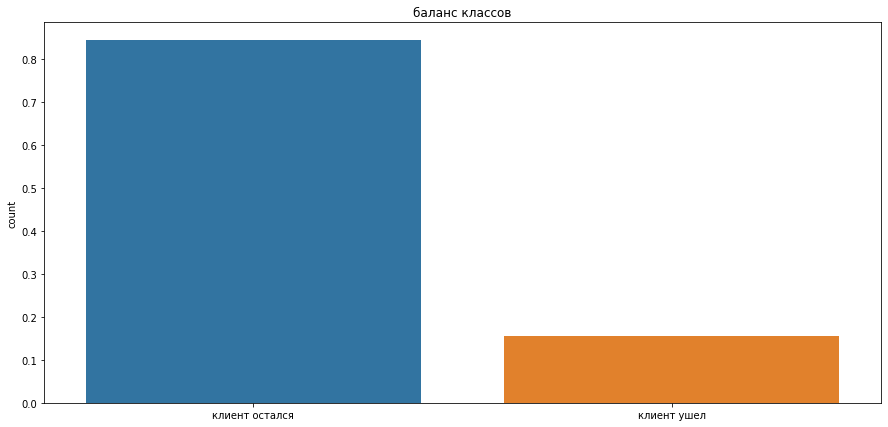

In [30]:
plt.figure(figsize=(15,7))
sns.barplot(x=[0,1], y = df['exit'].value_counts() / df.shape[0])
plt.xticks([0,1], ['клиент остался', 'клиент ушел'])
plt.title('баланс классов', fontsize = 12)
plt.show()

Поскольку у нас стоит задача, связанная с анализом оттока клиентов, я бы сделала "Портрет ушедшего пользователя"

In [31]:
data = df.drop(['customerID'], axis=1)

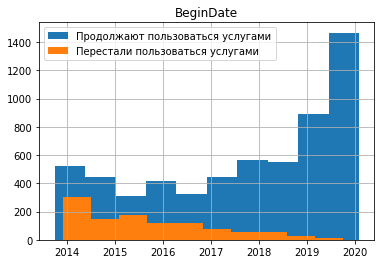

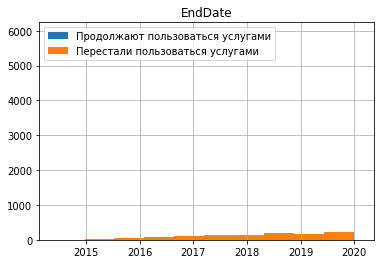

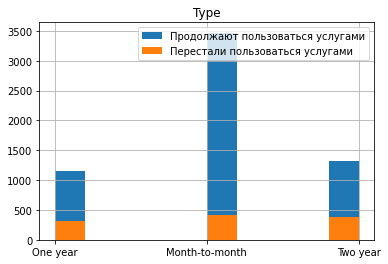

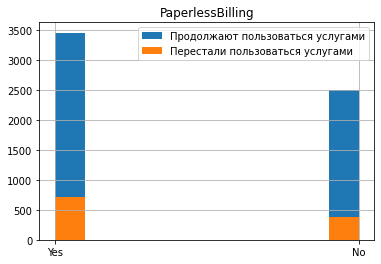

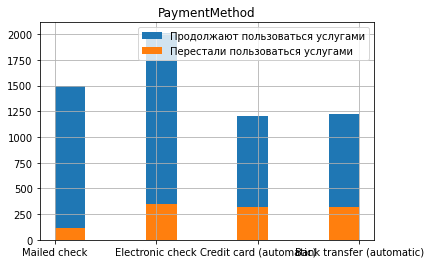

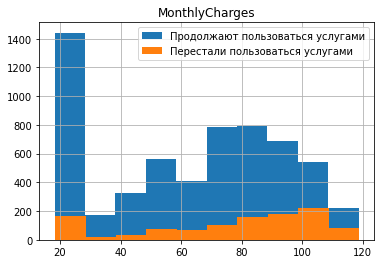

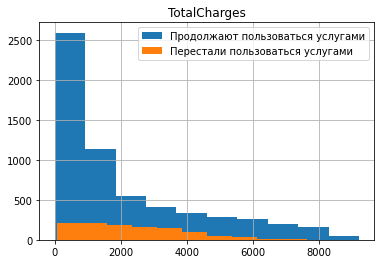

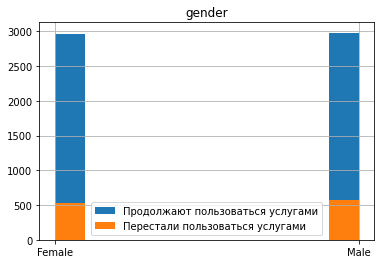

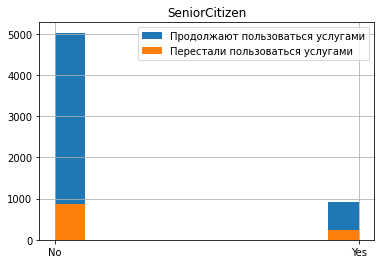

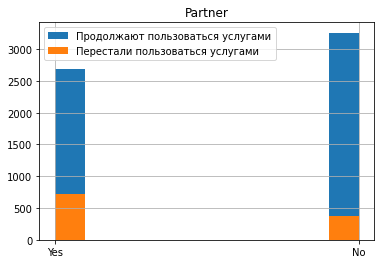

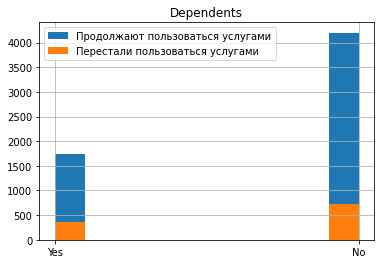

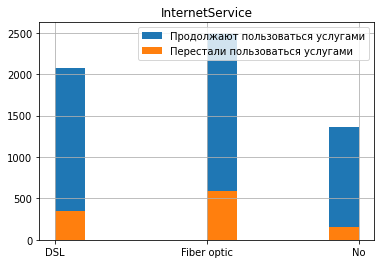

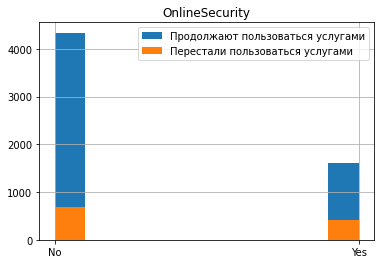

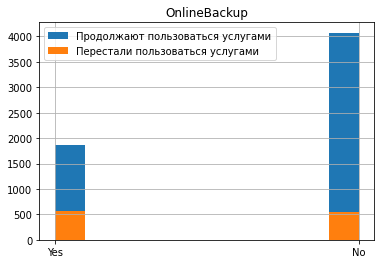

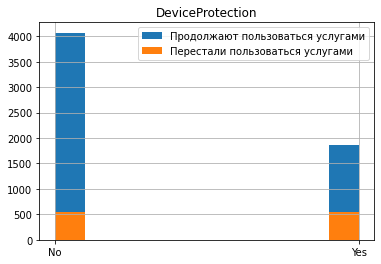

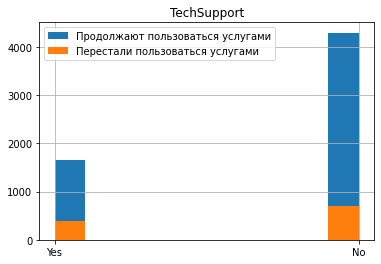

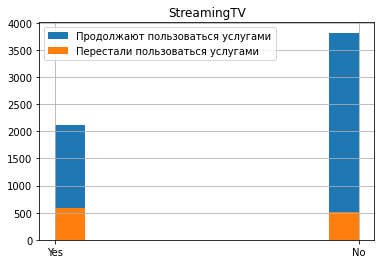

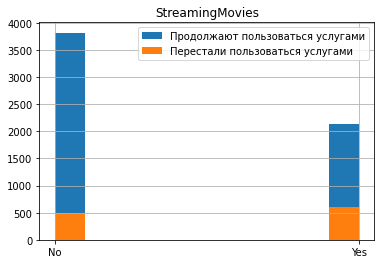

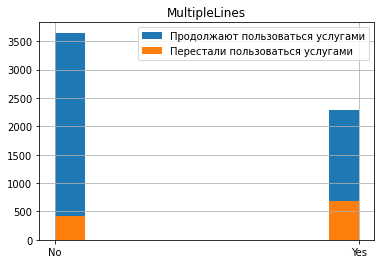

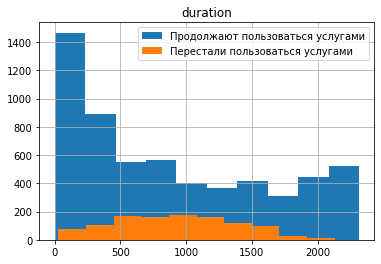

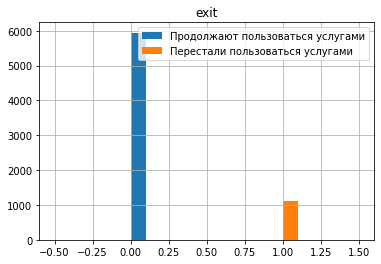

In [32]:
for column in data.columns:
    data.groupby('exit')[column].hist()
    plt.title(column)
    plt.legend(['Продолжают пользоваться услугами', 'Перестали пользоваться услугами'])
    plt.show()

Опишем портрет ушедшего пользователя:
- чаще всего польщователи уходт, кто пользовался услугами 2 года
- чаще уходят те, кто польщзуется электронным расчетом
- девушки немного чаще отказываются от услуг
- чаще уходят те, кто пользуется оптоволокном
- со временем, пользователя реже отказываются от услуг
- чаще уходят люди, которые только недавно начали пользоваться услугами 

Для дальнейшей работы, нам необходимо удалить признаки, которые больше не понадобятся

In [33]:
df.drop(['BeginDate', 'EndDate', 'customerID'], axis=1, inplace=True)

In [34]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,exit
0,One year,Yes,Mailed check,65.6,631.73,Female,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,276,0
1,Month-to-month,No,Mailed check,59.9,539.10,Male,No,No,No,DSL,No,No,No,No,No,Yes,Yes,276,0
2,Month-to-month,Yes,Electronic check,73.9,406.45,Male,No,No,No,Fiber optic,No,No,Yes,No,No,No,No,153,0
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,427,0
4,Month-to-month,Yes,Mailed check,83.9,444.67,Female,Yes,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,153,0


Необходимо провести корреляционный анализ

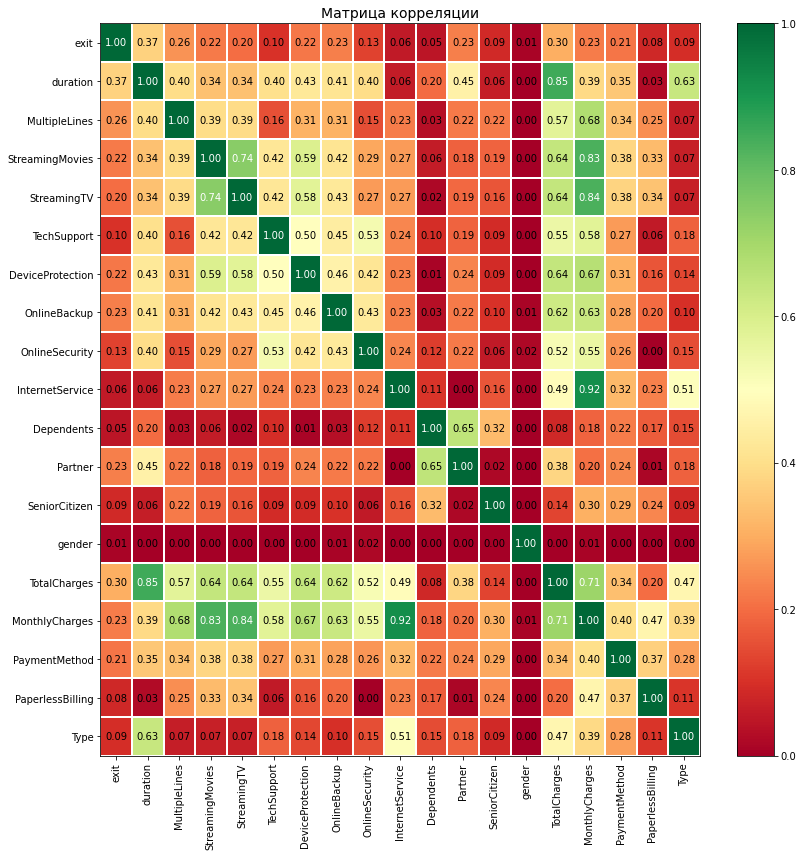

In [35]:
phik = df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'duration'])
phik.round(2)

plot_correlation_matrix(phik.values, 
                        x_labels=phik.columns, 
                        y_labels=phik.index, 
                        vmin=0, vmax=1, 
                        title=r"Матрица корреляции",  
                        figsize=(12, 12))
plt.tight_layout()
plt.show()

### Промежуточный вывод:
- создали новый столбец, в котором указали продолжительность пользования услугами - 'duration'
- добавмили новый признак exit, в котором 1 - клиент остался, 0 - ушел
- избавились от не информативных признаков, которые в дальнешем обучении модели не понадобятся 'BeginDate', 'EndDate', 'customerID'
- создали портрет ушедшего пользователя
- провели корреляционный анализ. Многие признаки имеют слабую связь с целевым признаком

## Подготовка данных

для обучения моделей, сформируем выборки

In [36]:
features = df.drop(['exit'], axis=1)
target = df['exit']

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [38]:
#для удобства выведем датафрейм на экран
features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
0,One year,Yes,Mailed check,65.6,631.73,Female,No,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,276
1,Month-to-month,No,Mailed check,59.9,539.10,Male,No,No,No,DSL,No,No,No,No,No,Yes,Yes,276
2,Month-to-month,Yes,Electronic check,73.9,406.45,Male,No,No,No,Fiber optic,No,No,Yes,No,No,No,No,153
3,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,427
4,Month-to-month,Yes,Mailed check,83.9,444.67,Female,Yes,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,153


Создадим список столбцов с категориальными признаками

In [39]:
cat_col = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'SeniorCitizen',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

Создадим список стобцов с количественными признаками

In [40]:
num_col_names = ['MonthlyCharges', 'TotalCharges', 'UseTime']

In [41]:
# Обработка категориальных признаков для GBM:
features_train_gbm = features_train.copy()
features_test_gbm = features_test.copy()

encoder = OrdinalEncoder()
features_train_gbm[cat_col] = encoder.fit_transform(features_train_gbm[cat_col])
features_test_gbm[cat_col] = encoder.transform(features_test_gbm[cat_col])

display(features_train_gbm.head())

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
4602,2.0,0.0,0.0,26.00,1773.20,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1888
3837,0.0,1.0,1.0,80.30,2888.39,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1005
7035,1.0,1.0,3.0,94.05,671.52,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,215
1849,0.0,0.0,0.0,33.60,2131.58,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1857
70,0.0,1.0,0.0,19.95,205.49,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306


## Обучение моделей

In [42]:
# Обучение GBM:
gbm = LGBMClassifier(random_state = RANDOM_STATE)
gbm_params = {'max_depth': np.arange(3, 10), 'learning_rate':[0.01, 0.1, 1]}

grid_gbm = GridSearchCV(gbm, 
                    gbm_params, 
                    cv = 3,
                    scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, average='binary', zero_division=1)},
                    refit = 'roc_auc').fit(features_train_gbm, target_train)

print('Лучшие параметры модели LGBMClassifier:', grid_gbm.best_params_)

Лучшие параметры модели LGBMClassifier: {'learning_rate': 1, 'max_depth': 5}


In [43]:
print('Лучший результат модели LGBMClassifier:', grid_gbm.best_score_)

Лучший результат модели LGBMClassifier: 0.858746357493941


In [44]:
results = pd.DataFrame.from_dict(grid_gbm.cv_results_)

In [45]:
#создадим таблицу, в которой сохраним результаты работы моделей
result = pd.DataFrame(columns = ['ROC_AUC', 'Precision'])

def res(name, roc_auc, precision):
    result.loc[name, ['ROC_AUC']] = roc_auc
    result.loc[name, ['Precision']] = precision
    return result

In [46]:
best_idx = results.sort_values(by='rank_test_roc_auc').head(1).index[0]

In [47]:
roc = results.loc[best_idx, 'mean_test_roc_auc']
pr = results.loc[best_idx, 'mean_test_precision']

In [48]:
res('LGBMClassifier', round(roc, 2), round(pr, 2))

,ROC_AUC,Precision
LGBMClassifier,0.86,0.66


In [49]:
pd.DataFrame.iteritems = pd.DataFrame.items

In [50]:
# Обучение CatBoost:
cbr = CatBoostClassifier(random_state = RANDOM_STATE, logging_level='Silent', loss_function='Logloss')
cbr_params = {'max_depth': np.arange(3, 10), 'learning_rate':[ 0.001, 0.01, 0.1, 1], 'iterations': [500,1000,1500]}

grid_cbr = GridSearchCV(cbr, cbr_params, cv=3, scoring=['roc_auc', 'precision'], refit = 'roc_auc')

grid_cbr.fit(features_train_gbm, target_train)

print('Лучшие параметры модели CatBoostClassifier:', grid_cbr.best_params_)

Лучшие параметры модели CatBoostClassifier: {'iterations': 1500, 'learning_rate': 0.1, 'max_depth': 3}


In [51]:
print('Лучший результат модели CatBoostClassifier:', grid_cbr.best_score_)

Лучший результат модели CatBoostClassifier: 0.9133583699194042


In [52]:
# Занесём результаты в табличку:
results = pd.DataFrame.from_dict(grid_cbr.cv_results_)
best_idx = results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = results.loc[best_idx, 'mean_test_roc_auc']
pr = results.loc[best_idx, 'mean_test_precision']

res('CatBoostClassifier', round(roc, 2), round(pr, 2))

,ROC_AUC,Precision
LGBMClassifier,0.86,0.66
CatBoostClassifier,0.91,0.85


### Выводы:
- обучили 2 модели: LGBMClassifierи CatBoostClassifier
- метрикой качества выступают метрики ROC_AUC и Precision
- лучшие показатели показала модель CatBoostClassifier с параметрами ROC_AUC 0.91 и Precision 0.85

## Тестирование лучшей модели на тестовой выборке

Лучшей моделью показала себя CatBoostClassifier. Протестируем её на тестовой выборке на лучших параметрах модели

In [62]:
y_pred_proba = grid_cbr.predict_proba(features_test_gbm)[:, 1]

In [63]:
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(target_test, y_pred_proba),2)}')

Метрика ROC-AUC на тестовой выборке: 0.94


In [64]:
#best_model = CatBoostClassifier(logging_level='Silent',
#                           loss_function='Logloss',
#                           iterations = 1500, 
#                           learning_rate = 0.1, 
#                           max_depth = 3,
#                           random_state = RANDOM_STATE).fit(features_train_gbm, target_train)
#predictions = best_model.predict(features_test_gbm)
#
#y_pred_proba = best_model.predict_proba(features_test_gbm)[:, 1]

In [65]:
#roc_auc = roc_auc_score(target_test, y_pred_proba)
#print(' метрика roc_auc на тестовом наборе данных:', round(roc_auc, 2))

На тестовом наборе данных лучшая модель показала даже лучший результат roc_auc = 0.94, чем на кросс валидации

In [69]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, f1_score, auc

In [84]:
# Важность признаков:
main_sign = pd.DataFrame(grid_cbr.best_estimator_.feature_importances_,
                         index = features_test.columns,
                         columns=['Важность признака'])
main_sign = main_sign.sort_values(by='Важность признака', ascending=False)
main_sign.iloc[:10]

,Важность признака
duration,57.072501
MonthlyCharges,11.628960
TotalCharges,10.010102
Type,5.250816
PaymentMethod,3.014184
Partner,2.485469
MultipleLines,2.024300
InternetService,1.795850
OnlineBackup,1.219112
Dependents,0.827660


### Самые главные признаки, влияющие на уход клиента
- длительность договора
- ежемесячные траты
- общая сумма трат
- тип оплаты

Остальные признаки влияют незначительно

## Построение матрицы ошибок

In [94]:
y_pred = grid_cbr.best_estimator_.predict(features_test_gbm)

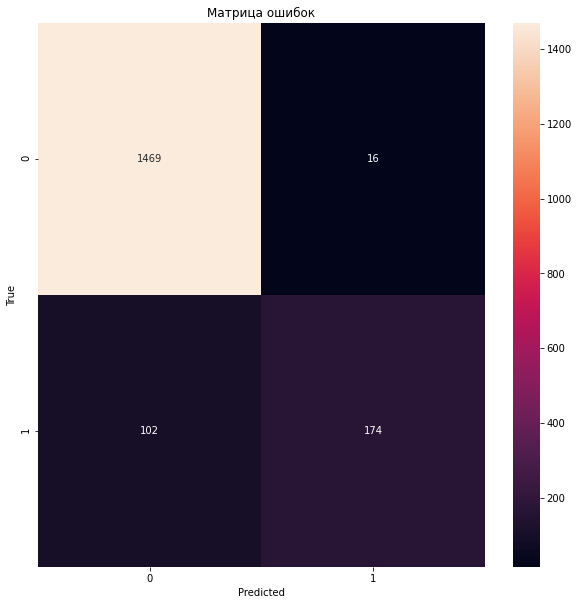

In [99]:
cm = confusion_matrix(target_test, y_pred)
plt.figure(figsize = (10 , 10))
plt.title("Матрица ошибок")
ax = sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True');

- истинно положительный (TP) - 1469
- истинно отрицательный (TN) - 174
- ложноположительный результат (FP), ошибка I рода - 16
- ложноотрицательный результат (FN), ошибка II рода 102

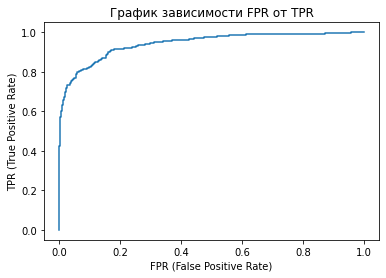

In [101]:
fpr, tpr, thresholds = roc_curve(target_test, y_pred_proba)   
plt.plot(fpr, tpr)     
plt.title("График зависимости FPR от TPR")
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.show()

## Итоговый вывод и рекомендации заказчику

В данном проекте заказчик предоставил нам 4 набора данных о своих клиентах. Задача стояла обучить модели, чтобы предсказать отток клиентов. Для этого проделали следущую работу:
- загрузили все представленные наборы данных и изучили общую информацию о них
- заполнили пропуски, изменили типы данных в некоторых признаках
- выполнили исследовательский анализ данных и предобработку
- объединили все исходные датафреймы в один
- добавили новые признаки
- удалили лишние столбцы
- построили матрицу корреляции. Многие признаки имеют слабую связь с целевым признаком
- составили "портрет" ушедшего пользователя:
* чаще всего польщователи уходт, кто пользовался услугами 2 года
* чаще уходят те, кто польщзуется электронным расчетом
* девушки немного чаще отказываются от услуг
* чаще уходят те, кто пользуется оптоволокном
* со временем, пользователя реже отказываются от услуг
* чаще уходят люди, которые только недавно начали пользоваться услугами
* пользователи со стриминговым сервисом отказывались чаще
* чем меньше потратил абонент, тем выше шанс его ухода
* те, кто платит ежемесячно
* имеют подключение к нескольким линиям

Для предсказания оттока клиентов обучили две модели - LGBMClassifier и CatBoostClassifier

Обе модели показали себя хорошо, однако лучшие метрики получились у CatBoostClassifier:
- ROC_AUC 0.91
- Precision 0.85

При следующих лучших параметрах модели: 'iterations': 1500, 'learning_rate': 0.1, 'max_depth': 3.

Протестировали лучшую модель на тестовой выборке, модель показала даже лучший результат: метрика roc_auc на тестовом наборе данных: 0.94

Исследовали важность признаков, влияющие на уход, это:
- длительность договора
- ежемесячные траты
- общая сумма трат
- тип оплаты

Построили матрицу ошибок: 
- истинно положительный (TP) - 1469
- истинно отрицательный (TN) - 174
- ложноположительный результат (FP), ошибка I рода - 16
- ложноотрицательный результат (FN), ошибка II рода 102

Рекомендации бизнесу:
- использовать модель CatBoostClassifier
- учитывая "портрет" ушедшего клиента, предлагать акции и скидки такому типу пользователей